<a href="https://colab.research.google.com/github/denyskononenko/ml_znodata/blob/master/zno_info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re 

from mpl_toolkits.basemap import Basemap
import plotly.graph_objects as go

from google.colab import drive


In [0]:
# mount google drive to use its content
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Read data from `.csv` dataset file which contains data with results of external independent test information for each participant. Raw dataset is uplaoded from the open data portal [OPENDATA. СТАТИСТИЧНІ ДАНІ ОСНОВНОЇ СЕСІЇ ЗНО](https://zno.testportal.com.ua/opendata).

**In current version data for 2019 year is processed.**

*Note: Dataset is stored on my personal gdrive, thereby run of this script after 12 hours requires new mount of the drive.*

### Dataset preparation

In [0]:
DATASET_PATH = "/content/gdrive/My Drive/Colab Notebooks/zno_info_project/dataset_zno_results/Odata2019File.csv"

def dataset_loader():
  """
  Function for loading the dataset 
  Returns
    data -- pd dataframe.
  """
  data = pd.DataFrame(pd.read_csv(DATASET_PATH, sep=';', comment='#', error_bad_lines=False, encoding="cp1251"))
  print("Total number of students who participate in ZNO in 2019: ", data.shape[0])
  return data

def dataset_filter(data):
  """
  Function to filter dataset: drop nan values
  replace coma with dot in numbers.
  Parameters
    data -- initial dataset
  Retruns
    filtered_data -- dataset with removed 
  """
  # filter data
  columns = [
             "Birth",
            "SEXTYPENAME",
            "AREANAME",
            "TERNAME",
            "TerTypeName",
            "ClassProfileNAME",
            "EONAME",
            "EOTYPENAME",
            "UkrBall100",
            "mathBall100",
            "engBall100",
            "physBall100"
            ]
  # drop nan and rename selected columns
  data = data[columns].dropna()
  ren_data = data.copy()
  ren_data = ren_data.rename(columns={"Birth": "birth",
                              "SEXTYPENAME": "gender",
                              "AREANAME": "areaname",
                              "TERNAME": "district_name",
                              "TerTypeName": "area_type",
                              "ClassProfileNAME": "class_profile_name",
                              "EONAME": "school",
                              "EOTYPENAME": "school_type",
                              "UkrBall100": "ukr",
                              "mathBall100": "math",
                              "engBall100": "eng",
                              "physBall100": "phys"
                      })

  # replace comma with dot in the marks values for successful converting to float
  ren_data["ukr"] = ren_data["ukr"].apply(lambda x: x.replace(",", "."))
  ren_data["math"] = ren_data["math"].apply(lambda x: x.replace(",", "."))
  ren_data["eng"] = ren_data["eng"].apply(lambda x: x.replace(",", "."))
  ren_data["phys"] = ren_data["phys"].apply(lambda x: x.replace(",", "."))

  return  ren_data

In [0]:
raw_data = dataset_loader()
proc_data = dataset_filter(raw_data)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning:

Columns (100,116,117,118,120,122,123,124,125) have mixed types. Specify dtype option on import or set low_memory=False.



Total number of students who participate in ZNO in 2019:  353813


In [0]:
# test select of data for Kyiv 
city_name = "м.Київ"
kyivData = proc_data[proc_data["areaname"] == city_name]
#kyivData["math"] = kyivData["math"].apply(pd.to_numeric) 

In [0]:
kyivData[:5]

,birth,gender,areaname,district_name,area_type,class_profile_name,school,school_type,ukr,math,eng,phys
467,2001,чоловіча,м.Київ,Оболонський район міста,місто,Інший(багатопрофільність),Спеціалізована школа № 214 Оболонського району...,спеціалізована школа,131.0,146.0,167.0,147.0
528,2002,чоловіча,м.Київ,Святошинський район міста,місто,Іноземної філології,Спеціалізована школа №200,спеціалізована школа,188.0,178.0,192.0,162.0
1003,2002,чоловіча,м.Київ,Дніпровський район міста,місто,Математичний,"Навчально-виховний комплекс №209 ""Сузір'я"" (по...",навчально-виховний комплекс,179.0,189.0,157.0,176.0
1706,2002,чоловіча,м.Київ,Деснянський район міста,місто,Спортивний,Загальноосвітня школа-інтернат спортивного про...,середня загальноосвітня школа,155.0,163.0,136.0,128.0
2360,2002,чоловіча,м.Київ,Шевченківський район міста,місто,Математичний,Технічний ліцей Шевченківського району м.Києва,ліцей,167.0,183.0,130.0,124.0


### Analysis of marks distribution in dataset

**Select sample with tests results on Math, Physics and Ukrainian language**

In [0]:
new_data = proc_data.copy()

# get data with marks frequency for tests in math physics and ukrainian
math_distribution = new_data["math"].value_counts(sort=True)
math_distribution = pd.DataFrame({'marks': np.sort(math_distribution.index.values.tolist()), 'number': math_distribution.values.tolist()})
math_median = new_data["math"].median()

phys_distribution = new_data["phys"].value_counts(sort=True)
phys_distribution = pd.DataFrame({'marks': np.sort(phys_distribution.index.values.tolist()), 'number': phys_distribution.values.tolist()})
phys_median = new_data["phys"].median()

ukr_distribution = new_data["ukr"].value_counts(sort=True)
ukr_distribution = pd.DataFrame({'marks': np.sort(ukr_distribution.index.values.tolist()), 'number': ukr_distribution.values.tolist()})
ukr_median = new_data["ukr"].median()


**Show distribution of marks frequencies for test in Math, Physics and Ukrainian language** 

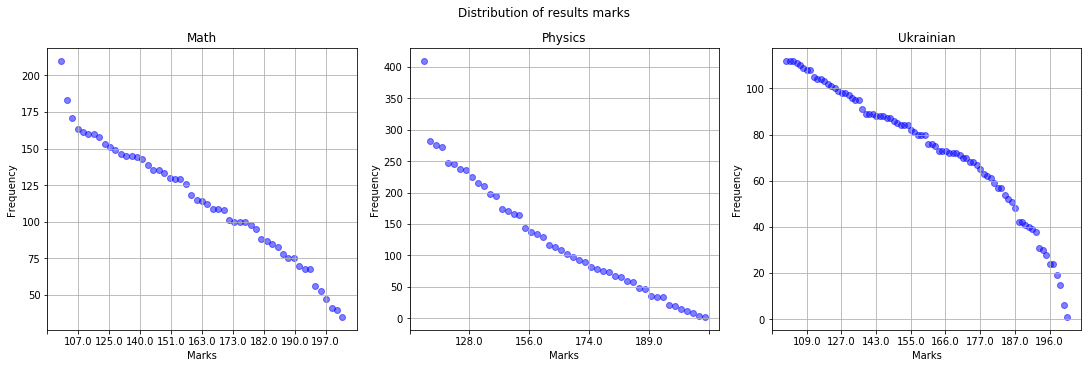

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize=(15,5))
fig.suptitle("Distribution of results marks", fontsize='large')
x = np.arange(0, 200, 1)

ax = axs[0]
ax.scatter(math_distribution.marks, math_distribution.number, color="b", alpha=0.5)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, (end - start)/10))
ax.set_xlabel("Marks")
ax.set_ylabel("Frequency")
ax.set_title(r"Math")
ax.grid(True)

ax = axs[1]
ax.scatter(phys_distribution.marks, phys_distribution.number, color="b", alpha=0.5)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))
ax.set_xlabel("Marks")
ax.set_ylabel("Frequency")
ax.set_title(r"Physics")
ax.grid(True)

ax = axs[2]
ax.scatter(ukr_distribution.marks, ukr_distribution.number, color="b", alpha=0.5)
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 10))
ax.set_xlabel("Marks")
ax.set_ylabel("Frequency")
ax.set_title(r"Ukrainian")
ax.grid(True)


As we can see low marks are the most common for selected subjects among the sample.

Personal statistics of one participant can be displayed in the form of radar chart.

In [0]:
# display radar chart
def display_radar_chart(person_data, categories, categories_names):
  """
  Display radar chart for results of distinct person
  Parameters
    dataset -- 
    person_id -- id of person from dataset
  """
  person_data = [float(mark) for mark in stats]
  fig = go.Figure()

  fig.add_trace(go.Scatterpolar(
        r=stats,
        theta=categories_names,
        fill='toself',
        name='Profile'
  ))

  fig.update_layout(
    polar=dict(
      radialaxis=dict(
        visible=True,
        range=[0, 200]
      )),
    showlegend=False
  )

  fig.show()


In [0]:
person_id = 160
categories = ['ukr', 'math', 'eng', 'phys']
categories_names = ['Ukrainian', 'Math', 'English', 'Physics']
personal_data = males_stat.loc[person_id, categories].values

display_radar_chart(personal_data, categories, categories_names)

### Gender Statistics

Here we plot mean marks on Mathematics, Physics and English for cities with respect to the gender. 
First split initial dataset into two: males and females data: 

In [0]:
# select data for genders results
males_stat = proc_data[proc_data["gender"] == "чоловіча"]
females_stat = proc_data[proc_data["gender"] == "жіноча"]

Find cities

In [0]:
unique = proc_data["areaname"].unique() 
uniq_cities = [el if re.match("м.", el) is not None else "" for el in unique]
uniq_cities = list(filter(lambda x: x != "", uniq_cities))
print(uniq_cities)

['м.Херсон', 'м.Кривий Ріг', 'м.Львів', 'м.Житомир', 'м.Київ', 'м.Дніпро', 'м.Харків', 'м.Полтава', 'м.Одеса', 'м.Миколаїв', 'м.Запоріжжя', 'м.Чернігів', "м.Кам'янське", 'м.Маріуполь', 'м.Олександрія', 'м.Івано-Франківськ', 'м.Черкаси', 'м.Суми', 'м.Кременчук', 'м.Червоноград', 'м.Добропілля', 'м.Чернівці', 'м.Кропивницький', 'м.Ірпінь', 'м.Селидове', 'м.Дрогобич', "м.Куп'янськ", 'м.Дружківка', 'м.Торецьк', 'м.Чорноморськ', 'м.Покровськ', 'м.Лисичанськ', 'м.Білгород-Дністровський']


In [0]:
irp_dat = females_stat[females_stat["areaname"] == 'м.Ірпінь']
print(len(irp_dat))

0


In [0]:
def mean_mark(data, city, subject):
  """
  Return mean mark in data among rows with particular cityname for particular subject
  Parameters
    data -- dataframe to select mean value of mark 
    city -- name of city 
    subject -- subject name 
  Returns 
    mean mark value on particular subject
  """
  city_data = data[data["areaname"] == city]
  if len(city_data) == 0:
    return 0
  else:
    return np.mean(np.array(city_data[subject], dtype=float))

Constuct data structure for each city with marks gender distribution for particular subject

```python
np.array[["City Name", men_mean_mark, women_mean_mark]]
```

In [0]:
women_men_mean_math = np.array([[city, mean_mark(males_stat, city, "math"), mean_mark(females_stat, city, "math")] for city in uniq_cities])
women_men_mean_physics = np.array([[city, mean_mark(males_stat, city, "phys"), mean_mark(females_stat, city, "phys")] for city in uniq_cities])
women_men_mean_english = np.array([[city, mean_mark(males_stat, city, "eng"), mean_mark(females_stat, city, "eng")] for city in uniq_cities])

In [0]:
def display_barchart(labels, men_means, women_means, subject_name):
  """
  Display bar chart.
  """
  x = np.arange(0, 2 * len(labels), 2)  # the label locations
  y = np.arange(0, 200, 10)
  width = 0.5  # the width of the bars

  fig, ax = plt.subplots(figsize=(20, 7))
  rects1 = ax.bar(x - width/2, np.array(men_means, dtype=float), width, label='Men')
  rects2 = ax.bar(x + width/2, np.array(women_means, dtype=float), width, label='Women')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Scores', fontsize=16)
  ax.set_title('Scores by cities and gender in ' + subject_name)
  ax.set_xticks(x)
  ax.set_xticklabels(labels, rotation=90)
  ax.set_yticks(y)
  ax.set_yticklabels(y)
  ax.tick_params(axis='both', which='major', labelsize=14)
  ax.legend()
  plt.show()

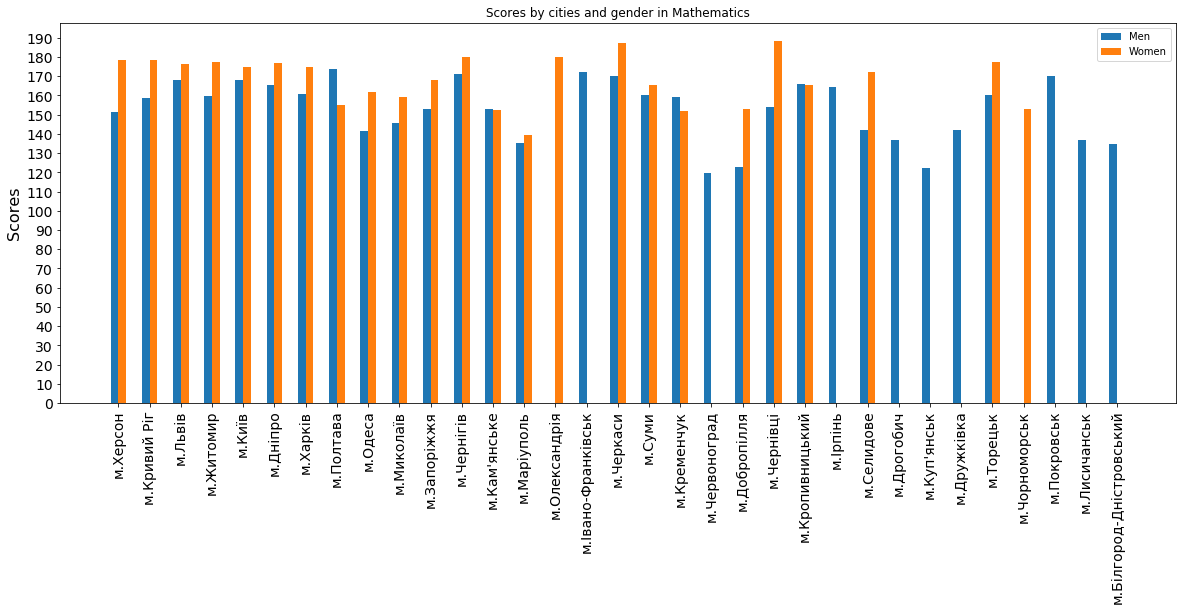

In [0]:
display_barchart(women_men_mean_math[:, 0], women_men_mean_math[:, 1], women_men_mean_math[:, 2], "Mathematics")

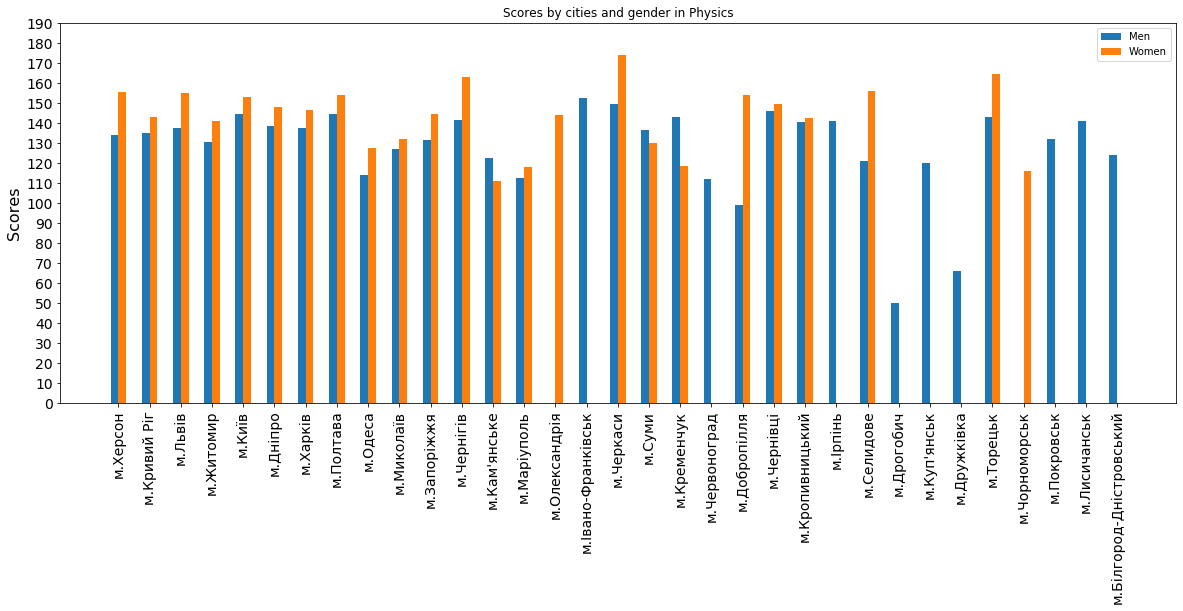

In [0]:
display_barchart(women_men_mean_physics[:, 0], women_men_mean_physics[:, 1], women_men_mean_physics[:, 2], "Physics")

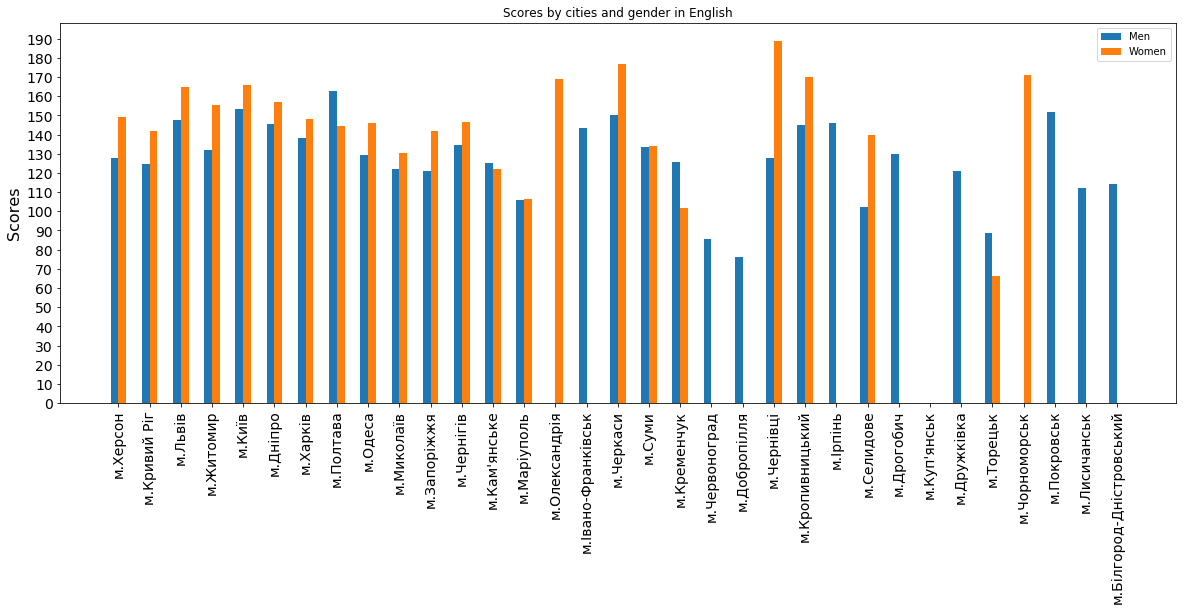

In [0]:
display_barchart(women_men_mean_english[:, 0], women_men_mean_english[:, 1], women_men_mean_english[:, 2], "English")

### Data distribution on the map 

In [0]:
cities =[
         {"lat": 50.584981, "lon": 30.235748, "name": "м.Київ"},
         {"lat": 49.85, "lon": 24.0166667, "name": "м.Львів"},    
         {"lat": 49.98967, "lon": 36.208309, "name": "м.Харків"},  
         {"lat": 46.653368, "lon": 32.629424, "name": "м.Херсон"}, 
         {"lat": 46.4666667, "lon": 30.7333333, "name": "м.Одеса"}, 
         {"lat": 48.45, "lon": 34.9833333, "name": "м.Дніпро"},
         {"lat": 47.899726, "lon": 33.379534, "name": "м.Кривий Ріг"},
         {"lat": 51.503653, "lon": 31.293167, "name": "м.Чернігів"},
         {"lat": 50.910561, "lon": 34.80566, "name": "м.Суми"},
         {"lat": 50.259749, "lon": 28.676248, "name": "м.Житомир"}, 
         {"lat": 47.853748, "lon": 35.157139, "name": "м.Запоріжжя"},
         {"lat": 48.9166667, "lon": 24.7166667, "name": "м.Івано-Франківськ"},
         {"lat": 46.9666667, "lon": 32.0, "name": "м.Миколаїв"},
         {"lat": 49.59269, "lon": 34.551159, "name": "м.Полтава"},
         {"lat": 49.4333333, "lon": 32.0666667, "name": "м.Черкаси"},
         {"lat": 48.3, "lon": 25.9333333, "name": "м.Чернівці"}, 
        ]

In [0]:
def city_medium_mark(city_name, subject):
  """
  Function for selecting medium mark of students from particular city
  for particular subject.
  Parameters
    city_name -- name of city to get data from
    subject -- subject of test
  Returns 
    (medium_mark (float), total_students_number (float)) -- real number
  """
  dataset = proc_data[proc_data["areaname"] == city_name]
  medium_mark = np.mean(np.array(dataset[subject], dtype=float))
  total_stud_number = len(np.array(dataset[subject], dtype=float))
  return medium_mark, total_stud_number


In [0]:
# match coordinates of city with its medium mark in corrsponding subject
data_coord_math = np.array([[item["lat"], item["lon"], *city_medium_mark(item["name"], "math")] for item in cities])
data_coord_phys = np.array([[item["lat"], item["lon"], *city_medium_mark(item["name"], "phys")] for item in cities])
data_coord_eng = np.array([[item["lat"], item["lon"], *city_medium_mark(item["name"], "eng")] for item in cities])

print(data_coord_math)

[[ 50.584981    30.235748   168.8013245  755.        ]
 [ 49.85        24.0166667  169.70238095 168.        ]
 [ 49.98967     36.208309   163.16012085 331.        ]
 [ 46.653368    32.629424   156.45192308 104.        ]
 [ 46.4666667   30.7333333  144.04984424 321.        ]
 [ 48.45        34.9833333  167.24152542 236.        ]
 [ 47.899726    33.379534   161.26241135 141.        ]
 [ 51.503653    31.293167   172.54901961 102.        ]
 [ 50.910561    34.80566    161.66304348  92.        ]
 [ 50.259749    28.676248   164.01666667  60.        ]
 [ 47.853748    35.157139   155.41481481 135.        ]
 [ 48.9166667   24.7166667  172.          20.        ]
 [ 46.9666667   32.         146.47651007 149.        ]
 [ 49.59269     34.551159   170.05555556  36.        ]
 [ 49.4333333   32.0666667  174.475       40.        ]
 [ 48.3         25.9333333  157.23809524  21.        ]]


In [0]:
def display_results_on_map(data_coord, subject_name):
  """
  Function for displaying results of ZNO in particular name on the map.
  Parameters
    data_coord -- dataset
    subject_name -- name of subject to display on the map
  """
  ukr_cord = (
              22.0856083513, 
              44.3614785833, 
              40.0807890155, 
              52.3350745713,
              )
  lon = data_coord[:, 1]
  lat = data_coord[:, 0]
  students_number = data_coord[:, 3]
  mark = data_coord[:, 2]

  fig = plt.figure(figsize=(20, 10))
  m = Basemap(projection='cyl', resolution='h', llcrnrlat=ukr_cord[1], urcrnrlat=ukr_cord[3],
  llcrnrlon=ukr_cord[0], urcrnrlon=ukr_cord[2],)
  m.shadedrelief()
  m.drawcoastlines(color='gray')
  m.drawcountries(color='gray')
  m.drawstates(color='gray')

  m.scatter(lon, lat, latlon=True,
                        c=mark, s=students_number,
                        cmap='seismic', alpha=0.5)

  plt.title(r"ZNO results in {} on the map of Ukraine".format(subject_name))
  plt.colorbar(label=r'mark') 
  plt.clim(100, 200)

  # make legend with dummy points
  for a in [100, 500, 1000]:
    plt.scatter([], [], c='k', alpha=0.5, s=a, label=str(a) + ' pupils')
  plt.legend(scatterpoints=1, frameon=False, labelspacing=3, loc='lower left');

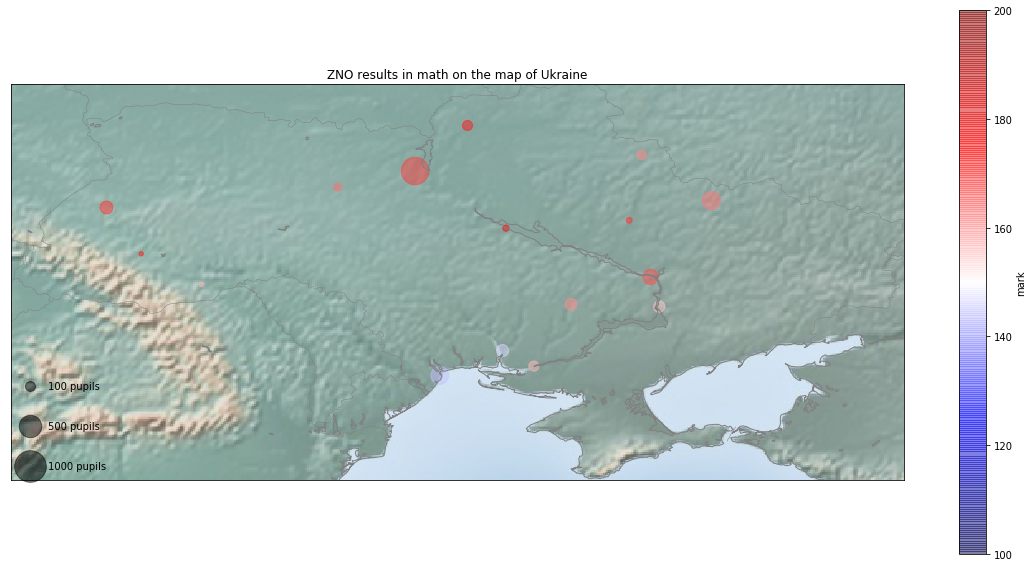

In [0]:
display_results_on_map(data_coord_math, "math")

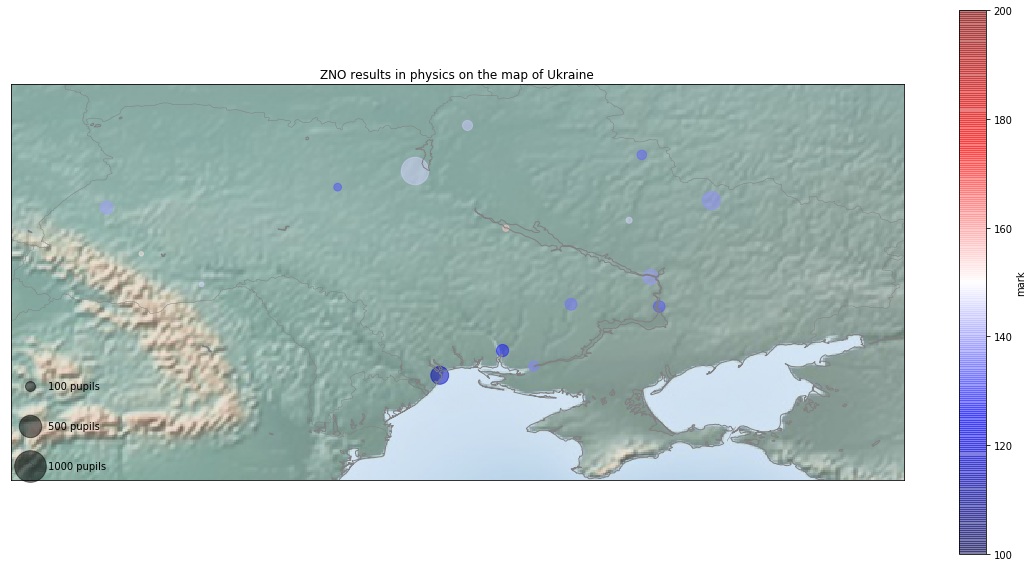

In [0]:
display_results_on_map(data_coord_phys, "physics")

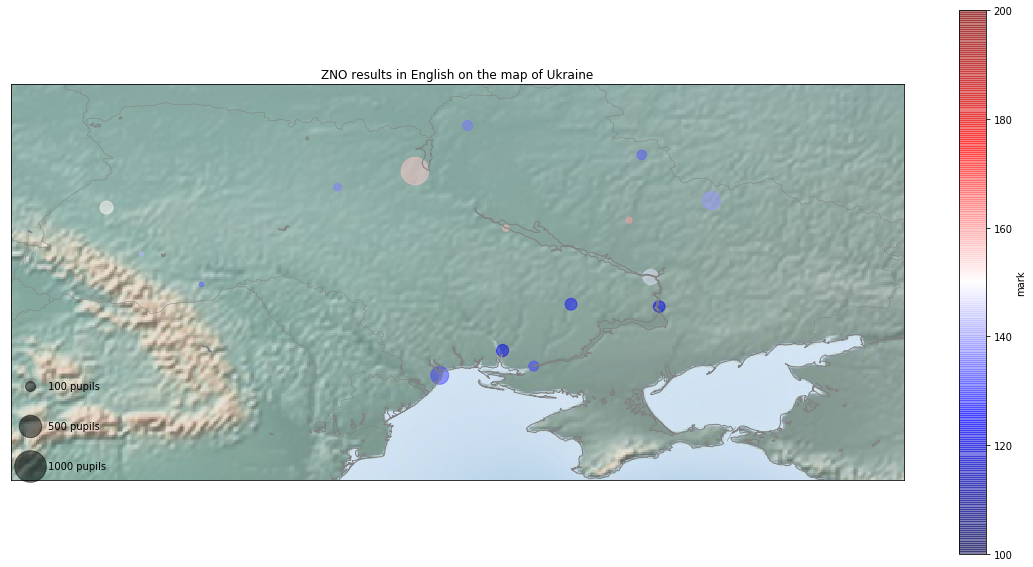

In [0]:
display_results_on_map(data_coord_eng, "English")

### Preparation staff: install used dependencies

In [0]:
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 73.1 kB of archives.
After this operation, 486 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Fetched 73.1 kB in 0s (166 kB/s)
Selecting previously unselected package libgeos-dev.
(Reading database ... 145605 files and directories currently installed.)
Pre

In [0]:
!pip install pyproj==1.9.6

     |████████████████████████████████| 2.8MB 2.8MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp36-cp36m-linux_x86_64.whl size=3702061 sha256=97ecdd9559ec0a3b380fe47b274dbdcfd66fb8be1810397876c70869398d5056
  Stored in directory: /root/.cache/pip/wheels/02/cd/b1/a2d6430f74c7a778a43d62f78bec109ca69c732dc9b929142a
Successfully built pyproj
  Found existing installation: pyproj 2.4.1
    Uninstalling pyproj-2.4.1:
      Successfully uninstalled pyproj-2.4.1
